<a href="https://colab.research.google.com/github/larsmoan/COMP3710/blob/main/eigenfaces_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#This times each cell being computed
%load_ext autotime

time: 360 µs (started: 2023-09-13 08:17:08 +10:00)


In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import torch
import matplotlib.pyplot as plt

time: 10.3 s (started: 2023-09-13 08:17:09 +10:00)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU is not available, using CPU instead
time: 12.2 ms (started: 2023-09-12 14:31:35 +10:00)


In [3]:
#Fetching the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

time: 180 ms (started: 2023-09-13 08:17:20 +10:00)


In [4]:
n_samples, height, width = lfw_people.images.shape
X = torch.from_numpy(lfw_people.data)
n_features = X.shape[1] #Number of features as number of pixels per image

#Fetching the label or target
y = torch.from_numpy(lfw_people.target)
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1217
n_features: 1850
n_classes: 6
time: 22.9 ms (started: 2023-09-13 08:17:32 +10:00)


In [5]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print(type(X), type(X_train), type(y_train), type(y_test))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
time: 44.4 ms (started: 2023-09-13 08:17:57 +10:00)


In [6]:
#Centering the data around the mean
mean = torch.mean(X, axis=0)  #From the notebook given they compute the mean from X_train, isn`t this wrong? Therefore I use X
X_train -= mean
X_test -= mean

#Eigen decomposition using SVD
U, S, Vh = torch.linalg.svd(X_train, full_matrices=False)
components = Vh[:n_components]
eigenfaces = components.reshape((n_components, height, width))

time: 747 ms (started: 2023-09-13 08:18:01 +10:00)


In [7]:
X_transformed = torch.matmul(X_train, components.T)
X_test_transformed = torch.matmul(X_test, components.T)

time: 63.2 ms (started: 2023-09-13 08:18:30 +10:00)


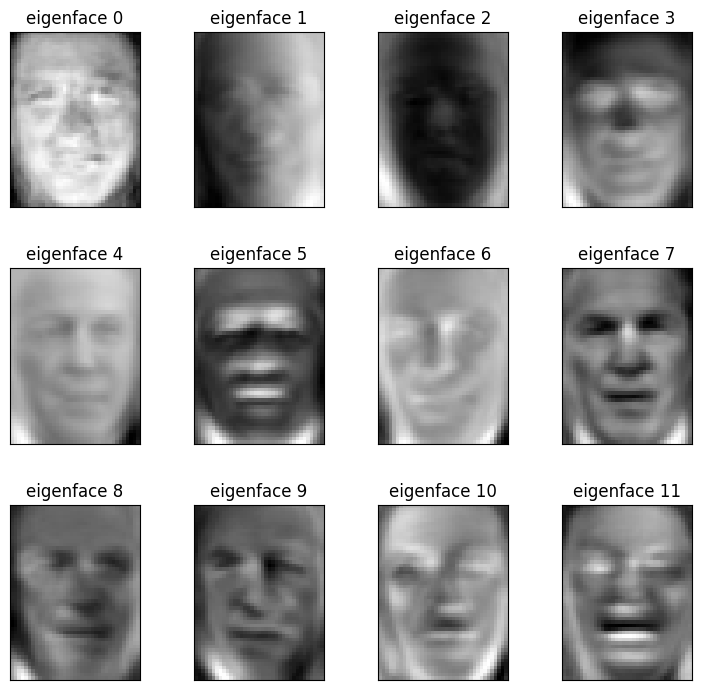

time: 2.13 s (started: 2023-09-13 08:18:54 +10:00)


In [8]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, height, width)

torch.Size([912])


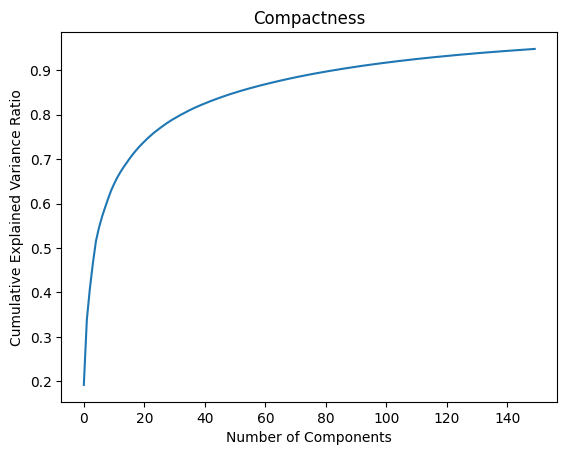

time: 746 ms (started: 2023-09-13 08:21:14 +10:00)


In [10]:
#Evaluating performance of the dimensionality reduction using a compactness plot
explained_variance = (S ** 2) / (n_samples - 1)

total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = torch.cumsum(explained_variance_ratio, dim=0)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [13]:
#Using the PCA face-space as features to build a random forest classifer of the original faces
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
print(X_transformed.is_cuda, y_train.is_cuda)
estimator.fit(X_transformed, y_train)

False False


RandomForestClassifier(max_depth=15, max_features=150, n_estimators=150)

time: 19.4 s (started: 2023-09-13 08:24:49 +10:00)


In [14]:
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test.numpy()
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
#print("Predictions", predictions)
#print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names, zero_division=np.nan))

Total Testing 305
Total Correct: 202
Accuracy: 0.6622950819672131
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.14      0.25        14
     Colin Powell       0.71      0.57      0.63        65
  Donald Rumsfeld       1.00      0.18      0.31        33
    George W Bush       0.62      0.96      0.76       133
Gerhard Schroeder       0.82      0.39      0.53        23
       Tony Blair       0.71      0.54      0.62        37

         accuracy                           0.66       305
        macro avg       0.81      0.46      0.52       305
     weighted avg       0.73      0.66      0.62       305

time: 107 ms (started: 2023-09-13 08:25:14 +10:00)


Comments about the exercise:
The use of pytorch functions here doesnt really makes sense as the randomforest classifier only works with numpy arrays. We therefore wont be able to utilize the GPU properly. I`ve checked and there is no equivalent to the randomforestclassifier supplied with torch.

Another thing, it seems that sometimes there is no Ariel Sharon's in the test_set and therefore it is not included properly in the classification report.
Therefore I used the np.nan flag for the zero_division